2024-11-04 21:08:18,748 - INFO - Data loaded successfully.
2024-11-04 21:08:18,779 - INFO - Data split into training and testing sets.
2024-11-04 21:08:18,793 - INFO - Handled rare categories in 'state_building'.
2024-11-04 21:08:18,816 - INFO - Handled rare categories in 'zip_code'.
2024-11-04 21:08:18,831 - INFO - Handled rare categories in 'locality'.
2024-11-04 21:08:18,842 - INFO - Handled rare categories in 'province'.
2024-11-04 21:08:18,887 - INFO - Data preprocessing completed.
2024-11-04 21:08:19,140 - INFO - Model training completed.
2024-11-04 21:08:19,184 - INFO - R-squared (Test): 0.6934
2024-11-04 21:08:19,185 - INFO - Mean Absolute Error (MAE): 42079.76
2024-11-04 21:08:19,185 - INFO - Median Absolute Error: 30489.45
2024-11-04 21:08:19,186 - INFO - Explained Variance Score: 0.6935
2024-11-04 21:08:19,187 - INFO - Mean Absolute Percentage Error (MAPE): 0.15%


First 10 Rows of Comparison:
       Actual Price  Predicted Price  Absolute Error  Percentage Error
3565       265000.0    321370.468750    56370.468750         21.271875
3798       200000.0    223060.468750    23060.468750         11.530234
4797       334900.0    402563.250000    67663.250000         20.204016
1898       172000.0    225207.609375    53207.609375         30.934657
10573      449000.0    365348.437500    83651.562500         18.630638
4635       274000.0    274472.468750      472.468750          0.172434
8633       297500.0    382604.062500    85104.062500         28.606408
5060       199000.0    253149.031250    54149.031250         27.210568
1255       252000.0    249444.484375     2555.515625          1.014094
8916       300000.0    398500.312500    98500.312500         32.833438


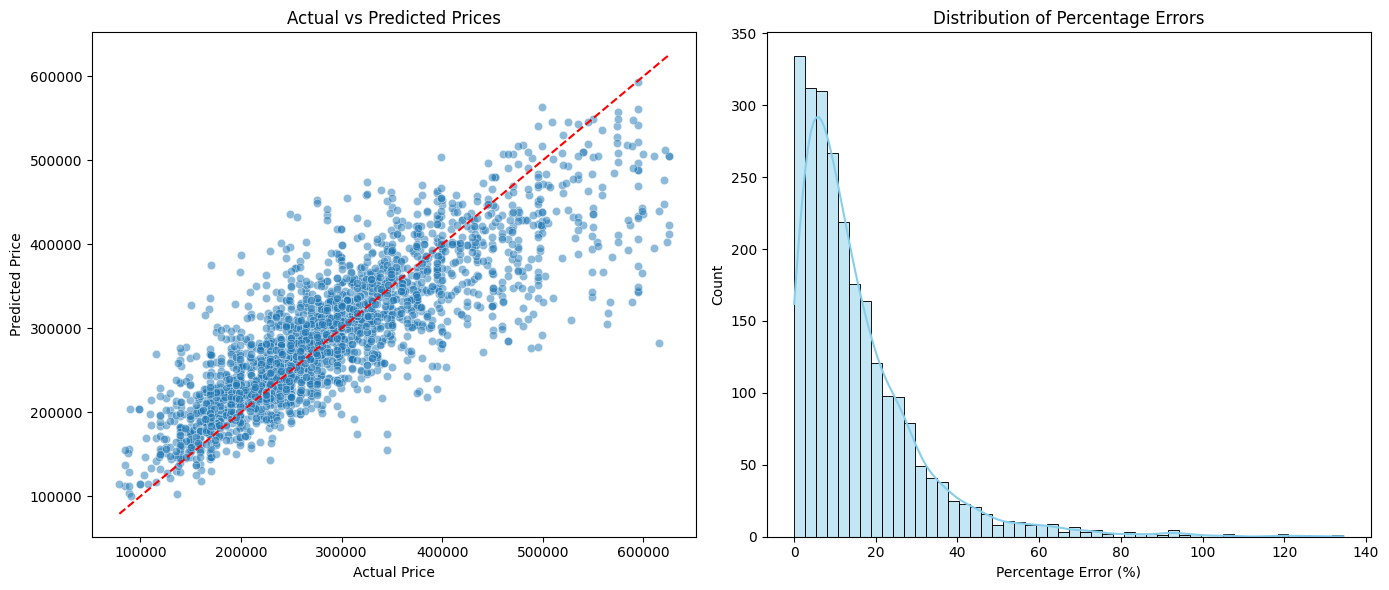

2024-11-04 21:08:19,584 - INFO - Model saved as 'appartments_xgb_model.joblib'.


In [3]:
import pandas as pd
import joblib
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error,
)
import xgboost as xgb

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Data Loading
try:
    df = pd.read_csv('apartments_sqm.csv')
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("File 'houses_sqm.csv' not found.")
    raise
except Exception as e:
    logging.error(f"Error loading data: {e}")
    raise

# 2. Data Preprocessing

# Define feature categories
cat_features = ['state_building', 
                'zip_code', 'locality', 'province']
num_features = ["total_area_sqm", "construction_year", "nbr_bedrooms", ]
dummy_features = ["fl_furnished", 
                  "fl_terrace","fl_double_glazing"]

# Separate features and target
X = df[num_features + dummy_features + cat_features]
y = df['price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=535
)
logging.info("Data split into training and testing sets.")

# Handle rare categories by grouping them into 'Other' and ensure all are strings
for cat in cat_features:
    top_categories = X_train[cat].value_counts().nlargest(50).index
    X_train[cat] = X_train[cat].apply(lambda x: str(x) if x in top_categories else 'Other')
    X_test[cat] = X_test[cat].apply(lambda x: str(x) if x in top_categories else 'Other')
    logging.info(f"Handled rare categories in '{cat}'.")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_features),
        ('dummy', 'passthrough', dummy_features)  # Assuming these are already binary
    ]
)

# Fit and transform the training data, transform the testing data
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)
logging.info("Data preprocessing completed.")

# Retrieve feature names after encoding
ohe_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_features = num_features + list(ohe_features) + dummy_features

# Convert to DataFrame for easier handling
X_train_enc = pd.DataFrame(X_train_enc.toarray(), columns=all_features, index=X_train.index)
X_test_enc = pd.DataFrame(X_test_enc.toarray(), columns=all_features, index=X_test.index)

# 3. Model Training
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=535
)
model.fit(X_train_enc, y_train)
logging.info("Model training completed.")

# 4. Model Evaluation
y_pred_test = model.predict(X_test_enc)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
median_ae = median_absolute_error(y_test, y_pred_test)
explained_variance = explained_variance_score(y_test, y_pred_test)
try:
    mape = mean_absolute_percentage_error(y_test, y_pred_test)
except ZeroDivisionError:
    mape = float('inf')  # Assign infinity if actual price is zero
    logging.warning("MAPE is infinity due to division by zero (actual price is zero).")

# Log evaluation metrics
logging.info(f"R-squared (Test): {r2:.4f}")
logging.info(f"Mean Absolute Error (MAE): {mae:.2f}")
logging.info(f"Median Absolute Error: {median_ae:.2f}")
logging.info(f"Explained Variance Score: {explained_variance:.4f}")
logging.info(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 5. Results Visualization

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test
})
comparison_df['Absolute Error'] = (comparison_df['Actual Price'] - comparison_df['Predicted Price']).abs()
comparison_df['Percentage Error'] = (comparison_df['Absolute Error'] / comparison_df['Actual Price']) * 100

# Display first 10 rows
print("First 10 Rows of Comparison:")
print(comparison_df.head(10))

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual Price', y='Predicted Price', data=comparison_df, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# Histogram of Percentage Errors
plt.subplot(1, 2, 2)
sns.histplot(comparison_df['Percentage Error'], bins=50, kde=True, color='skyblue')
plt.xlabel('Percentage Error (%)')
plt.title('Distribution of Percentage Errors')

plt.tight_layout()
plt.show()

# 6. Saving the Model
joblib.dump(model, 'appartments_xgb_model.joblib')
logging.info("Model saved as 'appartments_xgb_model.joblib'.")

2024-11-04 21:09:48,007 - INFO - Data loaded successfully.
2024-11-04 21:09:48,017 - INFO - Data split into training and testing sets.
2024-11-04 21:09:48,031 - INFO - Handled rare categories in 'state_building'.
2024-11-04 21:09:48,065 - INFO - Handled rare categories in 'zip_code'.
2024-11-04 21:09:48,080 - INFO - Handled rare categories in 'locality'.
2024-11-04 21:09:48,092 - INFO - Handled rare categories in 'province'.
2024-11-04 21:09:48,150 - INFO - Data preprocessing completed.
2024-11-04 21:09:48,479 - INFO - Model training completed.
2024-11-04 21:09:48,524 - INFO - R-squared (Test): 0.6341
2024-11-04 21:09:48,525 - INFO - Mean Absolute Error (MAE): 62908.33
2024-11-04 21:09:48,526 - INFO - Median Absolute Error: 47388.36
2024-11-04 21:09:48,527 - INFO - Explained Variance Score: 0.6343
2024-11-04 21:09:48,527 - INFO - Mean Absolute Percentage Error (MAPE): 0.22%


First 10 Rows of Comparison:
       Actual Price  Predicted Price  Absolute Error  Percentage Error
14198      419000.0    412480.093750     6519.906250          1.556064
19901      495000.0    461630.125000    33369.875000          6.741389
14802      295000.0    233991.546875    61008.453125         20.680832
10226      299000.0    384897.125000    85897.125000         28.728135
865        480000.0    428964.125000    51035.875000         10.632474
14779      437500.0    457508.593750    20008.593750          4.573393
4100       373900.0    356320.875000    17579.125000          4.701558
9177       210000.0    215789.953125     5789.953125          2.757121
12794      338000.0    330225.406250     7774.593750          2.300176
12903      362000.0    329537.718750    32462.281250          8.967481


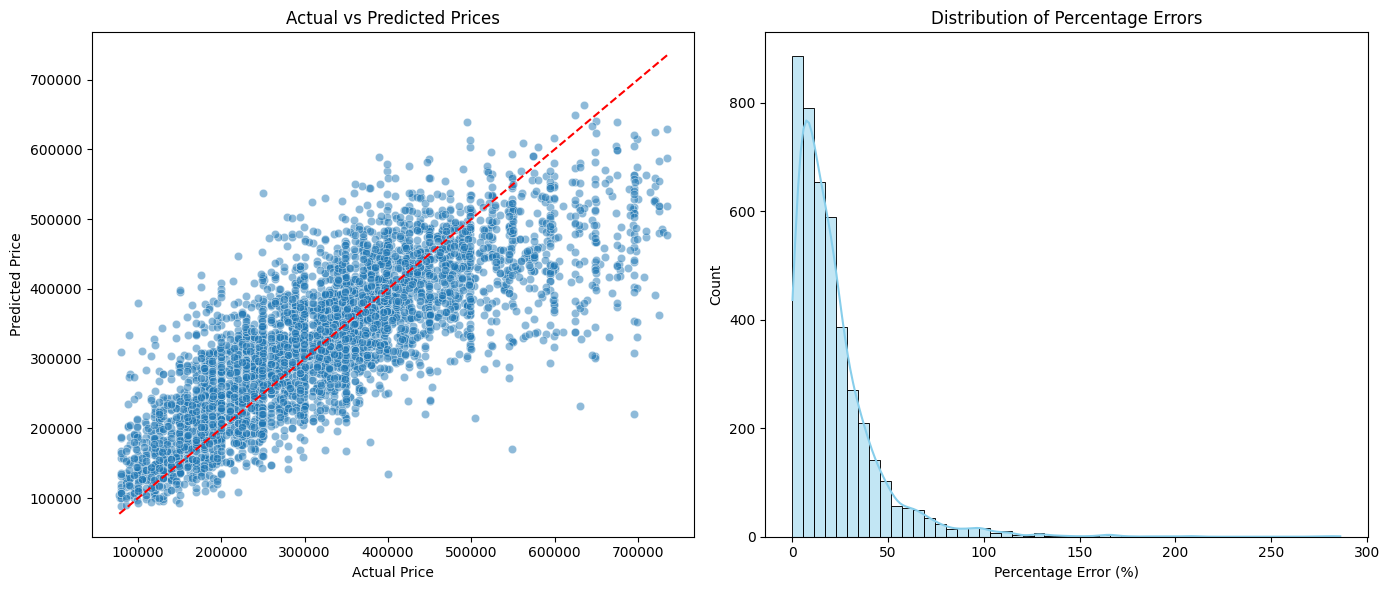

2024-11-04 21:09:48,936 - INFO - Model saved as 'appartments_xgb_model.joblib'.


In [6]:
import pandas as pd
import joblib
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error,
)
import xgboost as xgb

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Data Loading
try:
    df = pd.read_csv('houses_sqm.csv')
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("File 'houses_sqm.csv' not found.")
    raise
except Exception as e:
    logging.error(f"Error loading data: {e}")
    raise

# 2. Data Preprocessing

# Define feature categories
cat_features = ['state_building', 
                'zip_code', 'locality', 'province']
num_features = ["total_area_sqm", "construction_year", "nbr_bedrooms", ]
dummy_features = ["fl_furnished", 
                  "fl_terrace","fl_double_glazing"]

# Separate features and target
X = df[num_features + dummy_features + cat_features]
y = df['price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=535
)
logging.info("Data split into training and testing sets.")

# Handle rare categories by grouping them into 'Other' and ensure all are strings
for cat in cat_features:
    top_categories = X_train[cat].value_counts().nlargest(50).index
    X_train[cat] = X_train[cat].apply(lambda x: str(x) if x in top_categories else 'Other')
    X_test[cat] = X_test[cat].apply(lambda x: str(x) if x in top_categories else 'Other')
    logging.info(f"Handled rare categories in '{cat}'.")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_features),
        ('dummy', 'passthrough', dummy_features)  # Assuming these are already binary
    ]
)

# Fit and transform the training data, transform the testing data
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)
logging.info("Data preprocessing completed.")

# Retrieve feature names after encoding
ohe_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_features = num_features + list(ohe_features) + dummy_features

# Convert to DataFrame for easier handling
X_train_enc = pd.DataFrame(X_train_enc.toarray(), columns=all_features, index=X_train.index)
X_test_enc = pd.DataFrame(X_test_enc.toarray(), columns=all_features, index=X_test.index)

# 3. Model Training
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=535
)
model.fit(X_train_enc, y_train)
logging.info("Model training completed.")

# 4. Model Evaluation
y_pred_test = model.predict(X_test_enc)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
median_ae = median_absolute_error(y_test, y_pred_test)
explained_variance = explained_variance_score(y_test, y_pred_test)
try:
    mape = mean_absolute_percentage_error(y_test, y_pred_test)
except ZeroDivisionError:
    mape = float('inf')  # Assign infinity if actual price is zero
    logging.warning("MAPE is infinity due to division by zero (actual price is zero).")

# Log evaluation metrics
logging.info(f"R-squared (Test): {r2:.4f}")
logging.info(f"Mean Absolute Error (MAE): {mae:.2f}")
logging.info(f"Median Absolute Error: {median_ae:.2f}")
logging.info(f"Explained Variance Score: {explained_variance:.4f}")
logging.info(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 5. Results Visualization

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test
})
comparison_df['Absolute Error'] = (comparison_df['Actual Price'] - comparison_df['Predicted Price']).abs()
comparison_df['Percentage Error'] = (comparison_df['Absolute Error'] / comparison_df['Actual Price']) * 100

# Display first 10 rows
print("First 10 Rows of Comparison:")
print(comparison_df.head(10))

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual Price', y='Predicted Price', data=comparison_df, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# Histogram of Percentage Errors
plt.subplot(1, 2, 2)
sns.histplot(comparison_df['Percentage Error'], bins=50, kde=True, color='skyblue')
plt.xlabel('Percentage Error (%)')
plt.title('Distribution of Percentage Errors')

plt.tight_layout()
plt.show()

# 6. Saving the Model
joblib.dump(model, 'houses_xgb.joblib')
logging.info("Model saved as 'appartments_xgb_model.joblib'.")

# Below is more granular on zip_code
